In [1]:
%matplotlib inline


# Label Propagation digits active learning


Demonstrates an active learning technique to learn handwritten digits
using label propagation.

We start by training a label propagation model with only 10 labeled points,
then we select the top five most uncertain points to label. Next, we train
with 15 labeled points (original 10 + 5 new ones). We repeat this process
four times to have a model trained with 30 labeled examples. Note you can
increase this to label more than 30 by changing `max_iterations`. Labeling
more than 30 can be useful to get a sense for the speed of convergence of
this active learning technique.

A plot will appear showing the top 5 most uncertain digits for each iteration
of training. These may or may not contain mistakes, but we will train the next
model with their true labels.



In [2]:
print(__doc__)

# Authors: Clay Woolam <clay@woolam.org>
# License: BSD

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from sklearn import datasets
from sklearn.semi_supervised import label_propagation
from sklearn.metrics import classification_report, confusion_matrix

digits = datasets.load_digits()
rng = np.random.RandomState(0)
indices = np.arange(len(digits.data))
rng.shuffle(indices)

X = digits.data[indices[:330]]
y = digits.target[indices[:330]]
images = digits.images[indices[:330]]

n_total_samples = len(y)
n_labeled_points = 10
max_iterations = 5

unlabeled_indices = np.arange(n_total_samples)[n_labeled_points:]
print(len(unlabeled_indices))


Automatically created module for IPython interactive environment
320


In [3]:
np.random.seed(100)
tarr = np.random.randint(10, 40, size=(3, 6))
print(tarr, '\n',  np.argsort(tarr, axis=0))

[[18 34 13 17 33 25]
 [26 20 30 12 31 12]
 [12 24 12 27 26 34]] 
 [[2 1 2 1 2 1]
 [0 2 0 0 1 0]
 [1 0 1 2 0 2]]


In [4]:
sarr = np.array([10, 2, 3, 1, 4, 6])
sarr[::-1]

array([ 6,  4,  1,  3,  2, 10])

In [5]:
np.argsort(tarr)[::-1]

array([[0, 2, 1, 4, 3, 5],
       [3, 5, 1, 0, 2, 4],
       [2, 3, 0, 5, 4, 1]], dtype=int64)

In [6]:
np.in1d(np.array([1, 2, 3, 7]), np.array([1, 10, 12]))

array([ True, False, False, False], dtype=bool)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\semi_supervised\label_propagation.py:288: ConvergenceWarning: max_iter=5 was reached without convergence.
  category=ConvergenceWarning
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:65: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


Length predicted labels 270, length true labels 270
Iteration 0 ______________________________________________________________________
Label Spreading model: 60 labeled & 270 unlabeled (330 total)
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        22
          1       0.77      1.00      0.87        20
          2       1.00      0.96      0.98        27
          3       0.96      1.00      0.98        23
          4       1.00      0.92      0.96        24
          5       0.94      1.00      0.97        29
          6       1.00      0.97      0.99        39
          7       1.00      1.00      1.00        29
          8       0.95      0.88      0.91        24
          9       0.97      0.88      0.92        33

avg / total       0.96      0.96      0.96       270

Confusion matrix
[[22  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0]
 [ 0  0 26  1  0  0  0  0  0  0]
 [ 0  0  0 23  0  0  0  0  0  0]
 [ 0  1  0  0 2

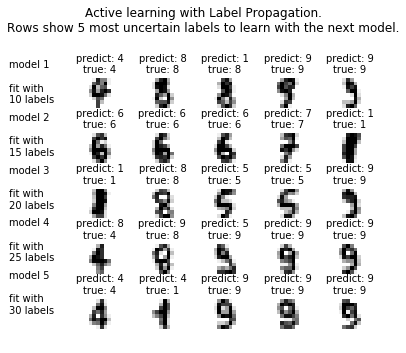

In [14]:
f = plt.figure()

for i in range(max_iterations):
    if len(unlabeled_indices) == 0:
        print("No unlabeled items left to label.")
        break
    y_train = np.copy(y)
    y_train[unlabeled_indices] = -1

    lp_model = label_propagation.LabelSpreading(gamma=0.25, max_iter=5)
    lp_model.fit(X, y_train)

    predicted_labels = lp_model.transduction_[unlabeled_indices]
    true_labels = y[unlabeled_indices]
    print('Length predicted labels {}, length true labels {}'.format(len(predicted_labels), len(true_labels)))
    cm = confusion_matrix(true_labels, predicted_labels,
                          labels=lp_model.classes_)

    print("Iteration %i %s" % (i, 70 * "_"))
    print("Label Spreading model: %d labeled & %d unlabeled (%d total)"
          % (n_labeled_points, n_total_samples - n_labeled_points,
             n_total_samples))

    print(classification_report(true_labels, predicted_labels))

    print("Confusion matrix")
    print(cm)
    print(cm.sum())

    # compute the entropies of transduced label distributions
    print('shape of lp model distributions: ', lp_model.label_distributions_.shape)
    print('first two rows of label_distributions: ', lp_model.label_distributions_[:2, :])
    pred_entropies = stats.distributions.entropy(
        lp_model.label_distributions_.T)
    
    print('pred_entropies shape ', pred_entropies.shape , ' and pred_entropies first five elements ', pred_entropies[:5])
    # select up to 5 digit examples that the classifier is most uncertain about
    uncertainty_index = np.argsort(pred_entropies)[::-1]
    uncertainty_index = uncertainty_index[
        np.in1d(uncertainty_index, unlabeled_indices)][:5]

    # keep track of indices that we get labels for
    delete_indices = np.array([])

    # for more than 5 iterations, visualize the gain only on the first 5
    if i < 5:
        f.text(.05, (1 - (i + 1) * .183),
               "model %d\n\nfit with\n%d labels" %
               ((i + 1), i * 5 + 10), size=10)
    for index, image_index in enumerate(uncertainty_index):
        image = images[image_index]

        # for more than 5 iterations, visualize the gain only on the first 5
        if i < 5:
            sub = f.add_subplot(5, 5, index + 1 + (5 * i))
            sub.imshow(image, cmap=plt.cm.gray_r, interpolation='none')
            sub.set_title("predict: %i\ntrue: %i" % (
                lp_model.transduction_[image_index], y[image_index]), size=10)
            sub.axis('off')

        # labeling 5 points, remote from labeled set
        delete_index, = np.where(unlabeled_indices == image_index)
        delete_indices = np.concatenate((delete_indices, delete_index))

    unlabeled_indices = np.delete(unlabeled_indices, delete_indices)
    n_labeled_points += len(uncertainty_index)

f.suptitle("Active learning with Label Propagation.\nRows show 5 most "
           "uncertain labels to learn with the next model.", y=1.15)
plt.subplots_adjust(left=0.2, bottom=0.03, right=0.9, top=0.9, wspace=0.2,
                    hspace=0.85)
plt.show()

In [12]:
stats.distributions.entropy([0.5, 5])

0.30463609734923813